# Testing some optics parts 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import time
import scipy
import pyfftw
from NN_utils import Lin_ONN

c:\ProgramData\anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


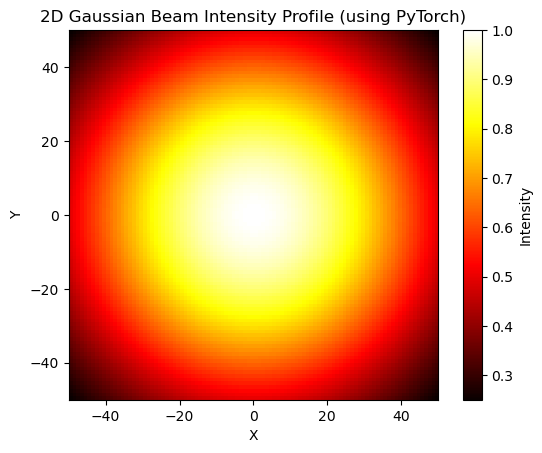

In [2]:


# Define parameters
N = 100  # Size of the array (NxN)
FWHM = N  # Set FWHM to be equal to the size of the array

# Calculate the standard deviation sigma
sigma = FWHM / (2 * torch.sqrt(2 * torch.log(torch.tensor(2.0))))

# Create a 2D grid of coordinates (using torch.linspace)
x = torch.linspace(-FWHM / 2, FWHM / 2, N)
y = torch.linspace(-FWHM / 2, FWHM / 2, N)
X, Y = torch.meshgrid(x, y)

# 2D Gaussian intensity profile
I = torch.exp(- (X**2 + Y**2) / (2 * sigma**2))

# Normalize the intensity to have a peak value of 1
I /= I.max()

# Convert to NumPy for plotting
I_numpy = I.numpy()

# Plot the intensity profile
plt.imshow(I_numpy, extent=[-FWHM/2, FWHM/2, -FWHM/2, FWHM/2], cmap='hot')
plt.colorbar(label='Intensity')
plt.title('2D Gaussian Beam Intensity Profile (using PyTorch)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Optionally, print the intensity array
# print(I)
